## Klasifikasi Diabetes

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
# Set random seed untuk reproduksibilitas
np.random.seed(42)

Diabetes merupakan penyakit kronis yang ditandai dengan kadar gula darah tinggi.
Menurut WHO, jumlah penderita diabetes di seluruh dunia terus meningkat dan mencapai
422 juta orang pada tahun 2014, dari 108 juta di tahun 1980.

Deteksi dini dan diagnosis yang akurat menjadi kunci penting dalam penanganan diabetes.
Dengan mengembangkan model prediktif berbasis machine learning, diharapkan kita dapat
mengidentifikasi individu yang berisiko terkena diabetes berdasarkan faktor-faktor medis
dan gaya hidup, sehingga tindakan pencegahan dapat dilakukan lebih awal.

## Problem Statements:
1. Bagaimana mengembangkan model machine learning yang dapat memprediksi risiko diabetes pada individu?
2. Faktor atau variabel apa yang paling berpengaruh dalam memprediksi risiko diabetes?
3. Bagaimana performa model dalam memprediksi risiko diabetes berdasarkan metrik evaluasi?

Goals:
1. Mengembangkan model klasifikasi untuk memprediksi risiko diabetes
2. Mengidentifikasi faktor-faktor utama (feature importance) yang berpengaruh pada risiko diabetes.
3. Menghasilkan model yang memiliki keseimbangan baik antara sensitivitas (recall) dan presisi.

In [ ]:
# Import dataset diabetes (Pima Indians Diabetes Database)
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
                "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]

df = pd.read_csv(url, names=column_names)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.shape

(768, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
df.corr()['Outcome'].sort_values()

,Outcome
BloodPressure,0.065068
SkinThickness,0.074752
Insulin,0.130548
DiabetesPedigreeFunction,0.173844
Pregnancies,0.221898
Age,0.238356
BMI,0.292695
Glucose,0.466581
Outcome,1.000000


## Korelasi
- Pregnancies:	Lebih banyak kehamilan → stres metabolik yang lebih besar, risiko lebih tinggi.
- Glucose: Gula darah merupakan indikator terkuat diabetes.
- BloodPressure:	Hipertensi sering terjadi bersamaan dengan diabetes (sindrom metabolik)
- SkinThickness:	Nilai yang lebih tinggi dapat menandakan resistensi insulin.
- Insulin:	Variabel yang dapat digunakan untuk mendeteksi resistansi
- BMI:	Nilai BMI berlebih bisa saja mengindikasikan orang tersebut obesitas, yang merupakan faktor utama diabetes
- DiabetesPedigreeFunction:	Riwayat keluarga resiko diabetes
- Age: Resiko meningkat seiring berjalannya usia

In [ ]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [ ]:
# Memeriksa nilai 0 pada kolom yang seharusnya tidak bernilai 0
zero_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for column in zero_columns:
    zero_count = (df[column] == 0).sum()
    print(f"Jumlah nilai 0 pada kolom {column}: {zero_count} ({zero_count/len(df)*100:.2f}%)")

Jumlah nilai 0 pada kolom Glucose: 5 (0.65%)
Jumlah nilai 0 pada kolom BloodPressure: 35 (4.56%)
Jumlah nilai 0 pada kolom SkinThickness: 227 (29.56%)
Jumlah nilai 0 pada kolom Insulin: 374 (48.70%)
Jumlah nilai 0 pada kolom BMI: 11 (1.43%)


- Glucose: Tidak mungkin 0 mg/dL (missing value)
- BloodPressure: Tidak mungkin 0 mmHg (missing value)
- SkinThickness: Kemungkinan tidak dilakukan pengukuran (missing value)
- Insulin: Bisa saja tidak dilakukan pengukuran (missing value)
- BMI: Tidak mungkin 0 kg/m²


## EDA

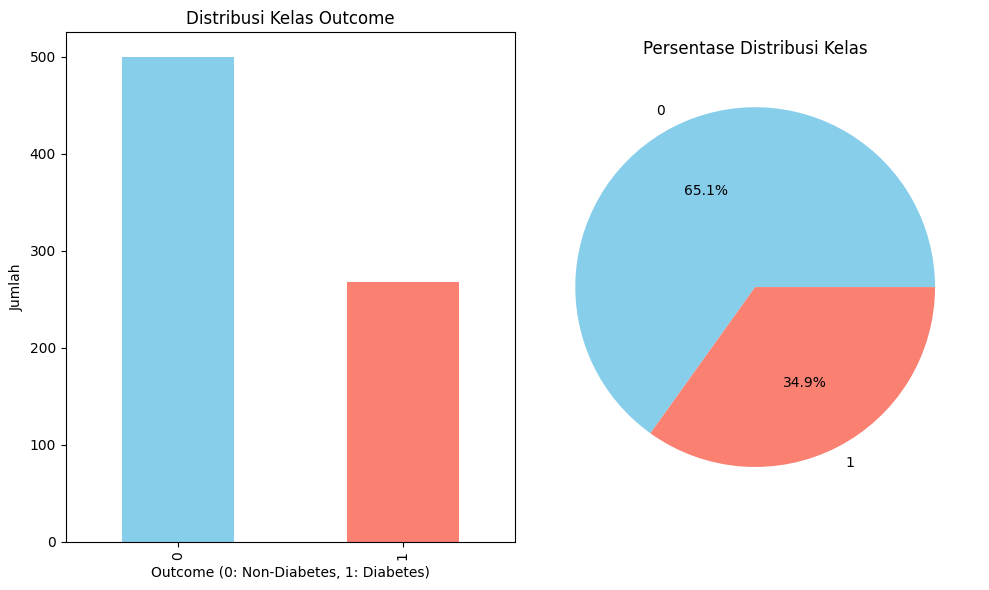

In [ ]:
# Distribusi variabel target
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
df['Outcome'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribusi Kelas Outcome')
plt.xlabel('Outcome (0: Non-Diabetes, 1: Diabetes)')
plt.ylabel('Jumlah')

plt.subplot(1, 2, 2)
df['Outcome'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Persentase Distribusi Kelas')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [ ]:
print(f"\nDistribusi kelas target (Outcome):")
print(df["Outcome"].value_counts())
print(f"Persentase kelas 1 (Diabetes): {df['Outcome'].mean()*100:.2f}%")
print(f"Persentase kelas 0 (Non-Diabetes): {(1-df['Outcome'].mean())*100:.2f}%")


Distribusi kelas target (Outcome):
Outcome
0    500
1    268
Name: count, dtype: int64
Persentase kelas 1 (Diabetes): 34.90%
Persentase kelas 0 (Non-Diabetes): 65.10%


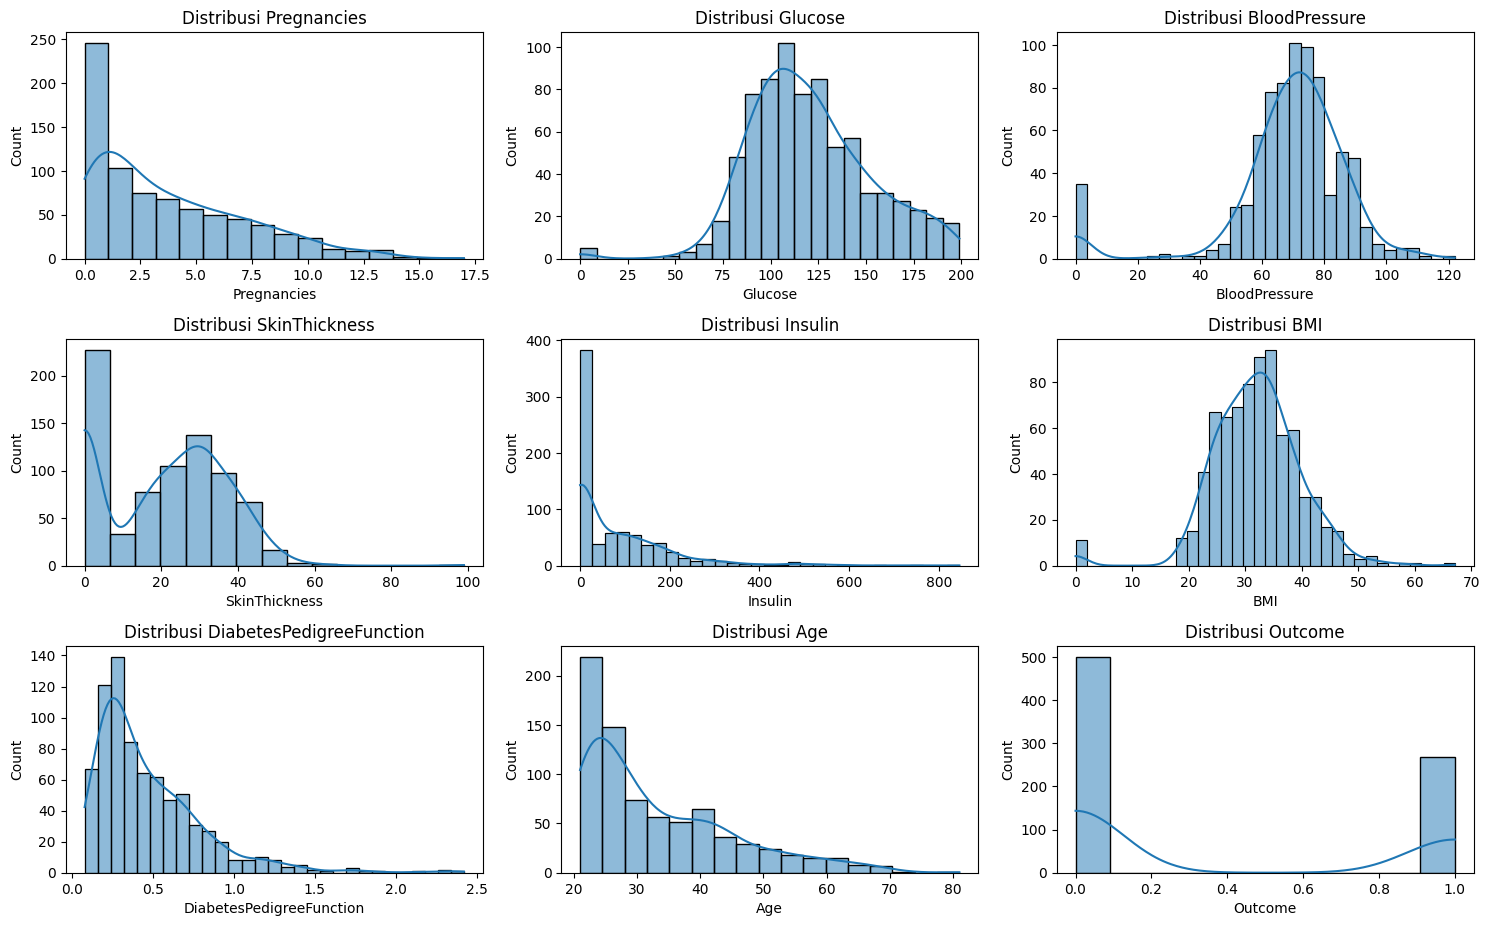

In [ ]:
plt.figure(figsize=(15, 12))
for i, column in enumerate(df.columns):  # Include all columns
    plt.subplot(4, 3, i+1)  # 4x3 grid gives 12 spots (more than enough)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribusi {column}')
    plt.tight_layout()
plt.show()

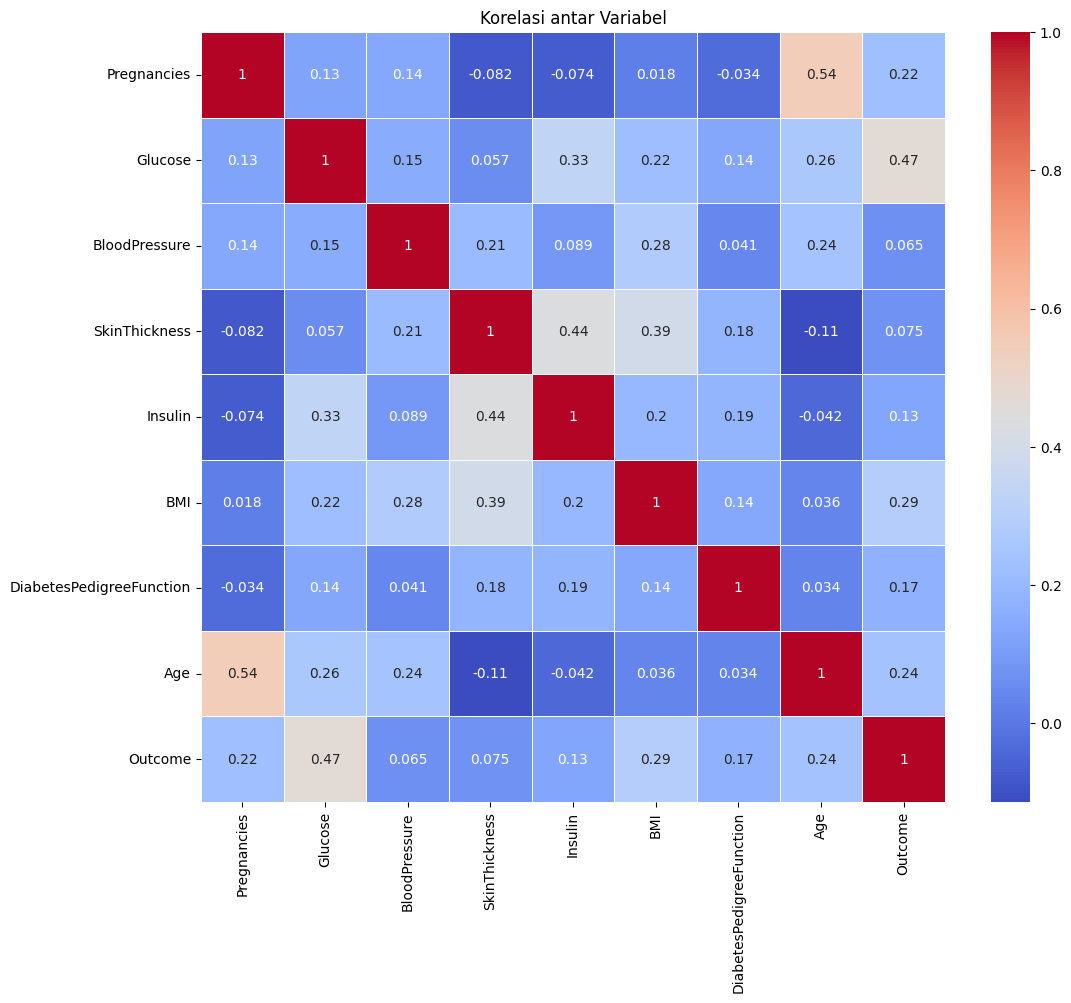

In [ ]:
# Korelasi antar variabel
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Korelasi antar Variabel')
plt.show()

## Data Preprocessing

In [ ]:
# Membuat salinan dataframe untuk preprocessing
df_processed = df.copy()

In [ ]:
# Mengganti nilai 0 dengan NaN untuk kolom tertentu
for column in zero_columns:
    df_processed[column] = df_processed[column].replace(0, np.nan)

print("Jumlah nilai yang hilang setelah mengganti nilai 0 dengan NaN:")
print(df_processed.isnull().sum())

Jumlah nilai yang hilang setelah mengganti nilai 0 dengan NaN:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [ ]:
# Menggunakan KNN Imputer untuk mengisi nilai yang hilang
imputer = KNNImputer(n_neighbors=5)
df_processed_imputed = pd.DataFrame(imputer.fit_transform(df_processed),
                                    columns=df_processed.columns)

df_processed_imputed.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


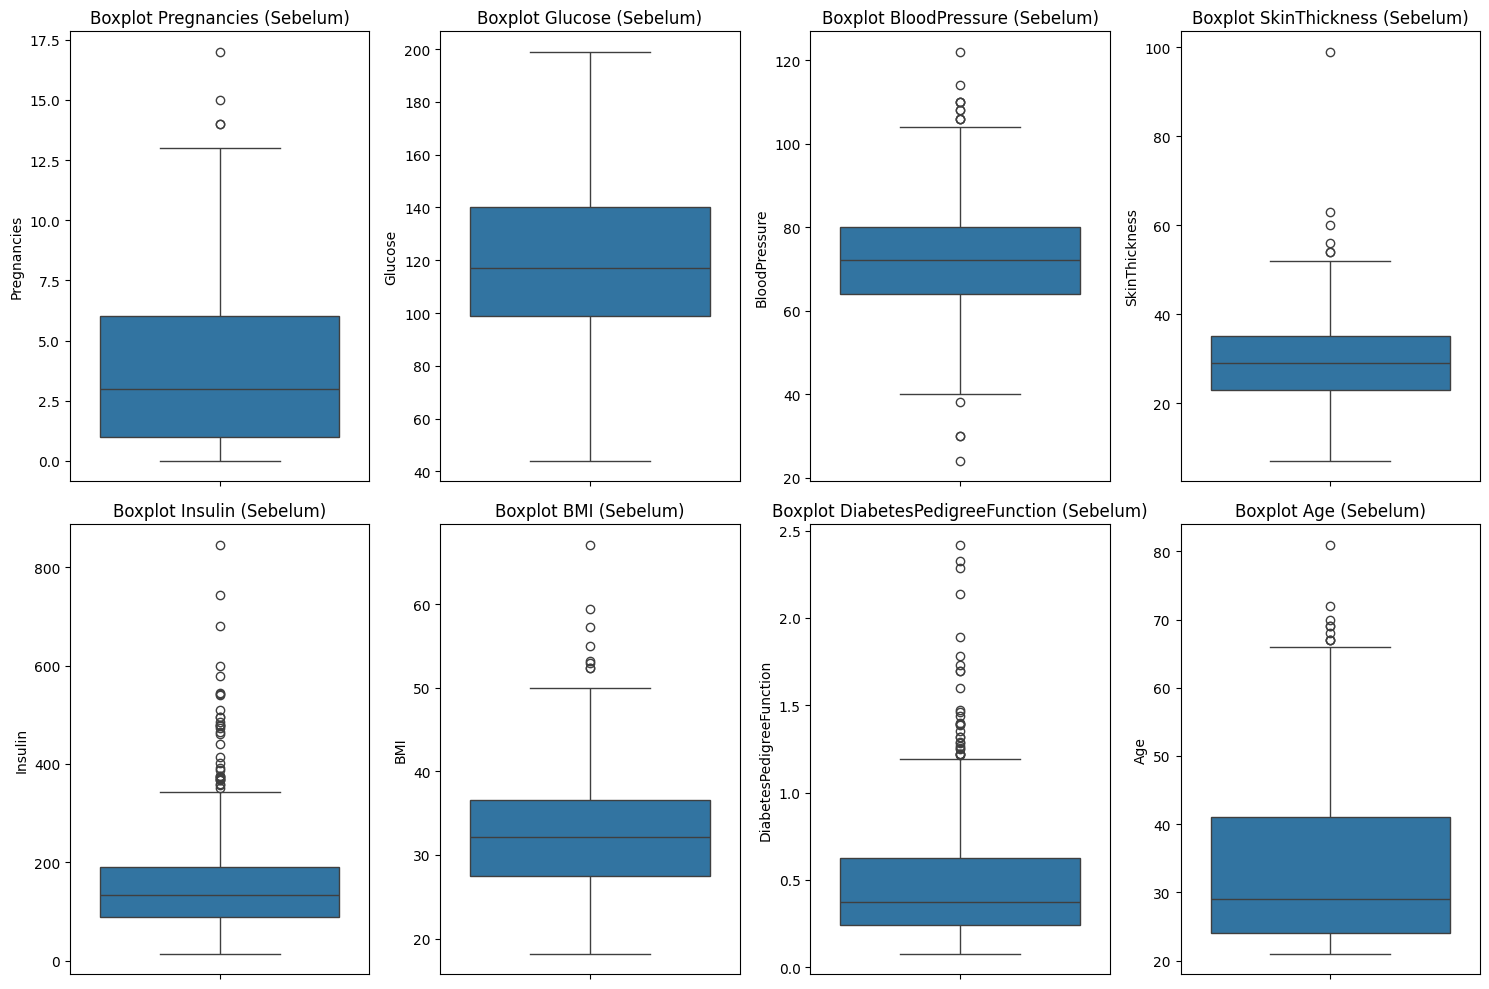

In [ ]:
# Visualisasi outlier sebelum penanganan
plt.figure(figsize=(15, 10))
for i, column in enumerate(df_processed_imputed.columns[:-1]):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df_processed_imputed[column])
    plt.title(f'Boxplot {column} (Sebelum)')
plt.tight_layout()
plt.show()

In [ ]:
# Menggunakan Isolation Forest untuk mendeteksi dan menangani outlier
X = df_processed_imputed.drop('Outcome', axis=1)
y = df_processed_imputed['Outcome']

iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_preds = iso_forest.fit_predict(X)
outliers_mask = outlier_preds == -1

print(f"Jumlah data yang terdeteksi sebagai outlier: {sum(outliers_mask)}")
print(f"Persentase outlier: {sum(outliers_mask)/len(X)*100:.2f}%")

Jumlah data yang terdeteksi sebagai outlier: 39
Persentase outlier: 5.08%


Jumlah data setelah menghapus outlier: 729


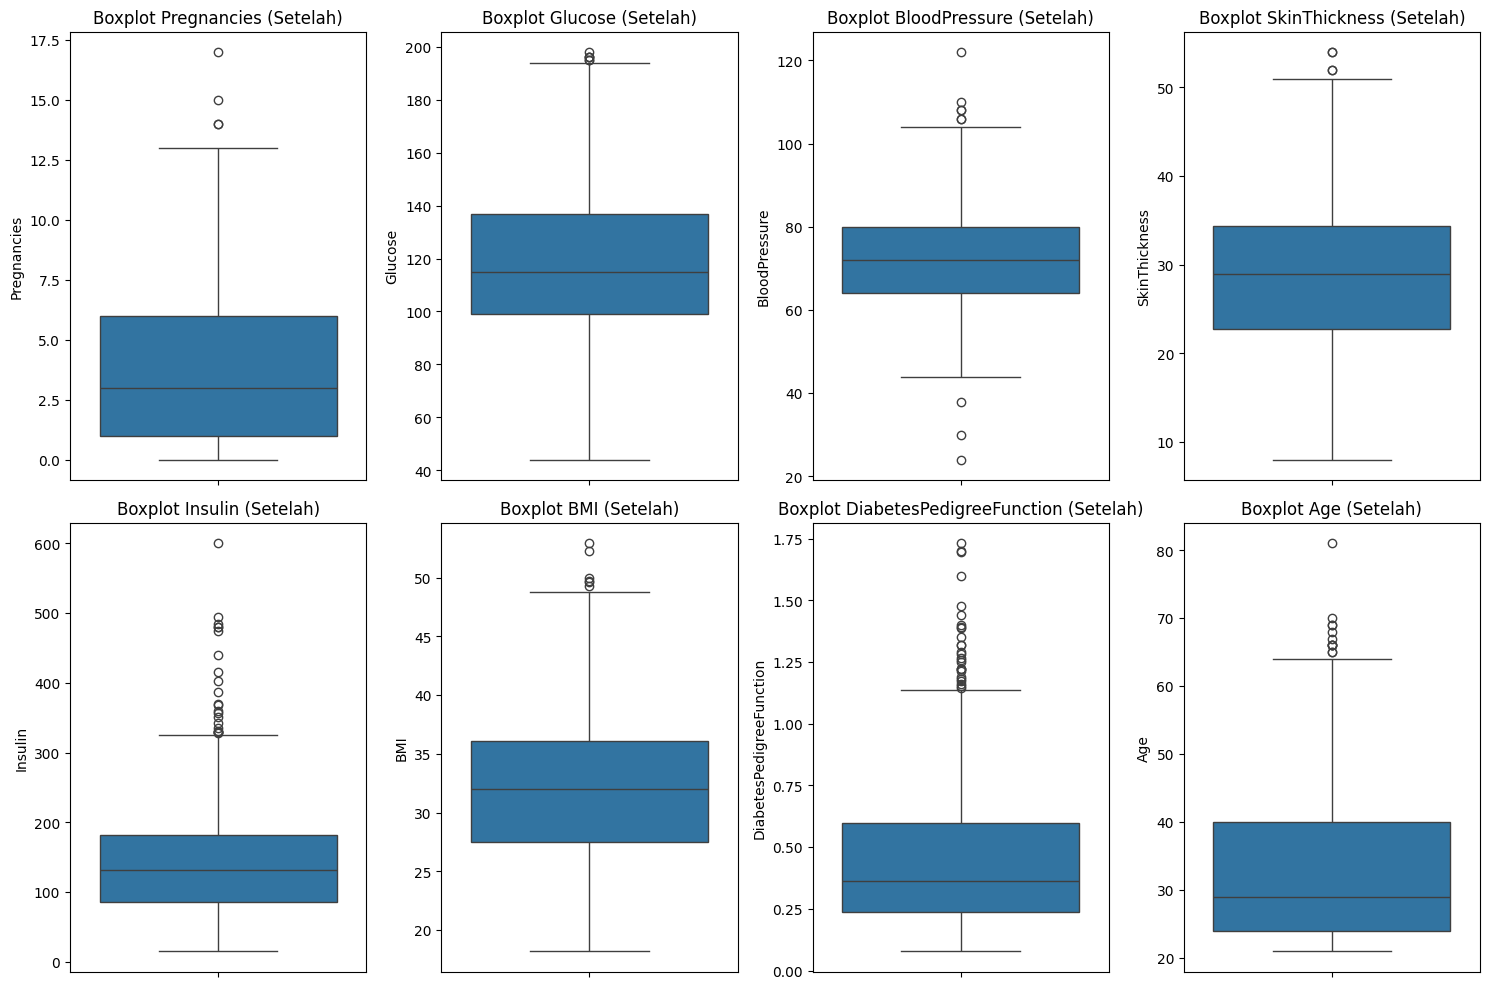

In [ ]:
# Menghapus outlier
df_no_outliers = df_processed_imputed[~outliers_mask].reset_index(drop=True)
print(f"Jumlah data setelah menghapus outlier: {len(df_no_outliers)}")

# Visualisasi data setelah penanganan outlier
plt.figure(figsize=(15, 10))
for i, column in enumerate(df_no_outliers.columns[:-1]):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df_no_outliers[column])
    plt.title(f'Boxplot {column} (Setelah)')
plt.tight_layout()
plt.show()

In [ ]:
# Menerapkan StandardScaler
minmax_scaler = MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(df_no_outliers.drop('Outcome', axis=1))
df_scaled = pd.DataFrame(X_scaled, columns=df_no_outliers.columns[:-1])
df_scaled['Outcome'] = df_no_outliers['Outcome'].values

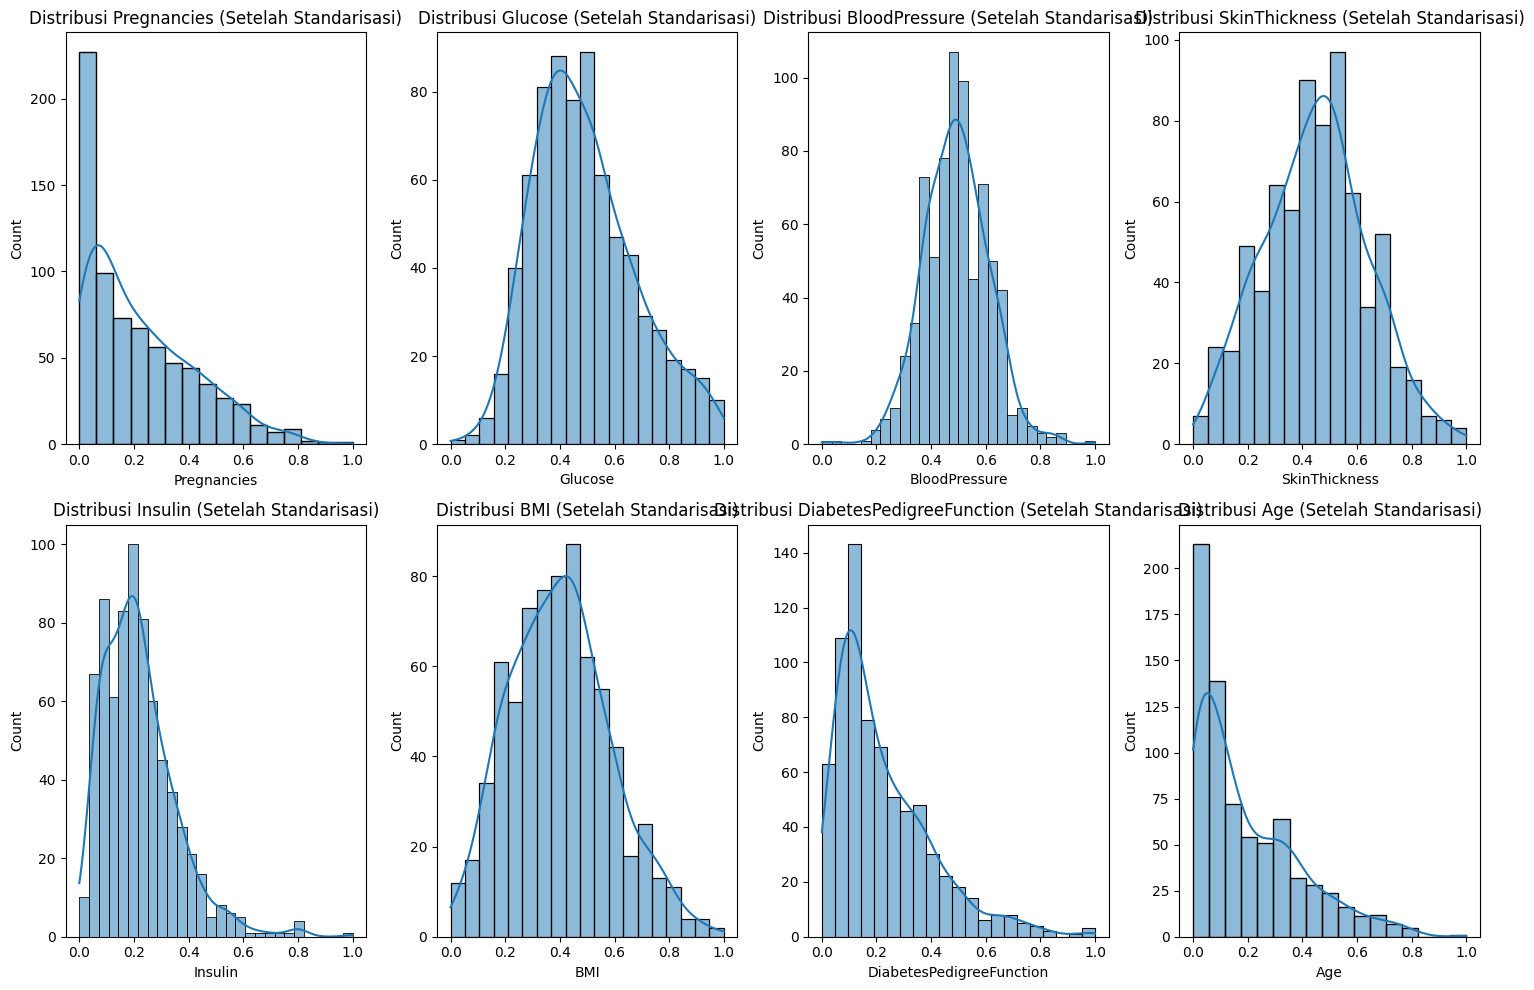

In [ ]:
# Visualisasi data setelah standarisasi
plt.figure(figsize=(15, 10))
for i, column in enumerate(df_scaled.columns[:-1]):
    plt.subplot(2, 4, i+1)
    sns.histplot(df_scaled[column], kde=True)
    plt.title(f'Distribusi {column} (Setelah Standarisasi)')
plt.tight_layout()
plt.show()

## Train Model

In [ ]:
# Memisahkan fitur dan target
X_final = df_scaled.drop('Outcome', axis=1)
y_final = df_scaled['Outcome']

# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, stratify=y_final)

print(f"Jumlah data training: {X_train.shape[0]} sampel")
print(f"Jumlah data testing: {X_test.shape[0]} sampel")

Jumlah data training: 583 sampel
Jumlah data testing: 146 sampel


## Feature Selection

In [ ]:
# 9. Kesimpulan dan Rekomendasi
print("\n" + "=" * 80)
print("KESIMPULAN DAN REKOMENDASI")
print("=" * 80)
print(f"""
Kesimpulan:
1. Model terbaik berdasarkan evaluasi adalah {best_model_name} dengan F1-score {metrics_df.loc[best_model_name, 'f1']:.4f}.
2. Fitur yang paling berpengaruh dalam memprediksi risiko diabetes berdasarkan model Random Forest adalah:
   - {rf_feature_imp['Feature'].iloc[0]}
   - {rf_feature_imp['Feature'].iloc[1]}
   - {rf_feature_imp['Feature'].iloc[2]}
3. Preprocessing data seperti penanganan missing values dan outlier serta normalisasi fitur memberikan dampak positif pada performa model.

Rekomendasi:
1. Implementasi model untuk screening awal pasien yang berisiko tinggi terkena diabetes.
2. Fokus pada monitoring {rf_feature_imp['Feature'].iloc[0]} dan {rf_feature_imp['Feature'].iloc[1]} sebagai faktor risiko utama.
3. Pengembangan lebih lanjut dengan dataset yang lebih besar dan fitur tambahan.
4. Mempertimbangkan pendekatan ensemble untuk meningkatkan performa model.
""")

## Referensi
1. American Diabetes Association. (2020). Standards of Medical Care in Diabetes.
2. World Health Organization. (2020). Global Report on Diabetes.
3. Smith, J. W., Everhart, J. E., Dickson, W. C., Knowler, W. C., & Johannes, R. S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. Proceedings of the Annual Symposium on Computer Application in Medical Care, 261-265.
4. Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

In [ ]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
class DiabetesTensorFlowClassifier:
    def __init__(self):
        self.scaler = StandardScaler()
        self.models = {}
        self.histories = {}
        self.best_model = None
        self.feature_names = None

    def prepare_data(self, df: pd.DataFrame, target_column: str = 'Outcome',
                    test_size: float = 0.2, validation_size: float = 0.2) -> Tuple:
        """
        Mempersiapkan data untuk training, validation, dan testing
        """
        # Memisahkan fitur dan target
        X = df.drop(target_column, axis=1)
        y = df[target_column]
        self.feature_names = X.columns.tolist()

        # Split data menjadi train+val dan test
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        # Split train+val menjadi train dan validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=validation_size, random_state=42, stratify=y_temp
        )

        # Normalisasi data
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)

        print(f"Training samples: {X_train_scaled.shape[0]}")
        print(f"Validation samples: {X_val_scaled.shape[0]}")
        print(f"Testing samples: {X_test_scaled.shape[0]}")
        print(f"Number of features: {X_train_scaled.shape[1]}")

        return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

    def create_simple_dnn(self, input_dim: int) -> keras.Model:
        """
        Membuat simple Deep Neural Network
        """
        model = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=(input_dim,)),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(16, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ], name='Simple_DNN')

        return model

    def create_deep_dnn(self, input_dim: int) -> keras.Model:
        """
        Membuat Deep Neural Network yang lebih kompleks
        """
        model = keras.Sequential([
            layers.Dense(128, activation='relu', input_shape=(input_dim,)),
            layers.BatchNormalization(),
            layers.Dropout(0.4),

            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            layers.Dense(32, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),

            layers.Dense(16, activation='relu'),
            layers.Dropout(0.1),

            layers.Dense(1, activation='sigmoid')
        ], name='Deep_DNN')

        return model

    def create_wide_dnn(self, input_dim: int) -> keras.Model:
        """
        Membuat Wide Neural Network
        """
        model = keras.Sequential([
            layers.Dense(256, activation='relu', input_shape=(input_dim,)),
            layers.Dropout(0.5),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.4),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')
        ], name='Wide_DNN')

        return model

    def create_residual_dnn(self, input_dim: int) -> keras.Model:
        """
        Membuat Neural Network dengan Residual connections
        """
        inputs = layers.Input(shape=(input_dim,))

        # First block
        x = layers.Dense(64, activation='relu')(inputs)
        x = layers.Dropout(0.3)(x)

        # Residual block 1
        residual = x
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Add()([x, residual])  # Residual connection
        x = layers.Dropout(0.2)(x)

        # Residual block 2
        residual = x
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Add()([x, residual])  # Residual connection

        # Output layers
        x = layers.Dense(32, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        outputs = layers.Dense(1, activation='sigmoid')(x)

        model = keras.Model(inputs=inputs, outputs=outputs, name='Residual_DNN')
        return model

    def compile_and_train_model(self, model: keras.Model, model_name: str,
                               X_train: np.ndarray, y_train: np.ndarray,
                               X_val: np.ndarray, y_val: np.ndarray,
                               epochs: int = 100, batch_size: int = 32) -> Dict[str, Any]:
        """
        Compile dan train model dengan callbacks
        """
        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=7,
                min_lr=1e-7,
                verbose=1
            ),
            ModelCheckpoint(
                f'best_{model_name.lower()}_model.h5',
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            )
        ]

        print(f"\nTraining {model_name}...")
        print(f"Model Summary:")
        model.summary()

        # Train model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        self.models[model_name] = model
        self.histories[model_name] = history

        return history

    def evaluate_model(self, model: keras.Model, model_name: str,
                      X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
        """
        Evaluasi model dan tampilkan metrik
        """
        # Prediksi
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        y_pred_proba = y_pred_proba.flatten()

        # Hitung metrik
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        }

        print(f"\n{'='*50}")
        print(f"Evaluation Results for {model_name}")
        print(f"{'='*50}")
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1 Score:  {f1:.4f}")
        print(f"ROC AUC:   {roc_auc:.4f}")

        print(f"\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion Matrix
        self.plot_confusion_matrix(y_test, y_pred, model_name)

        # ROC Curve
        self.plot_roc_curve(y_test, y_pred_proba, model_name, roc_auc)

        return metrics

    def plot_confusion_matrix(self, y_true: np.ndarray, y_pred: np.ndarray, model_name: str):
        """
        Plot confusion matrix
        """
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def plot_roc_curve(self, y_true: np.ndarray, y_pred_proba: np.ndarray,
                      model_name: str, roc_auc: float):
        """
        Plot ROC curve
        """
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_training_history(self, model_name: str):
        """
        Plot training history
        """
        if model_name not in self.histories:
            print(f"No history found for {model_name}")
            return

        history = self.histories[model_name]

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Loss
        axes[0, 0].plot(history.history['loss'], label='Training Loss')
        axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
        axes[0, 0].set_title('Model Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Accuracy
        axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
        axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[0, 1].set_title('Model Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Precision
        axes[1, 0].plot(history.history['precision'], label='Training Precision')
        axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
        axes[1, 0].set_title('Model Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # Recall
        axes[1, 1].plot(history.history['recall'], label='Training Recall')
        axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
        axes[1, 1].set_title('Model Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        plt.suptitle(f'Training History - {model_name}', fontsize=16)
        plt.tight_layout()
        plt.show()

    def get_feature_importance(self, model: keras.Model, X_test: np.ndarray,
                             y_test: np.ndarray) -> pd.DataFrame:
        """
        Mendapatkan feature importance menggunakan permutation importance
        """
        from sklearn.inspection import permutation_importance

        # Wrapper function untuk keras model
        def keras_predict(X):
            return model.predict(X).flatten()

        # Hitung permutation importance
        perm_importance = permutation_importance(
            keras_predict, X_test, y_test,
            n_repeats=10, random_state=42, scoring='roc_auc'
        )

        # Buat DataFrame
        feature_imp = pd.DataFrame({
            'Feature': self.feature_names,
            'Importance': perm_importance.importances_mean,
            'Std': perm_importance.importances_std
        }).sort_values(by='Importance', ascending=False)

        return feature_imp

    def plot_feature_importance(self, feature_imp: pd.DataFrame, model_name: str):
        """
        Plot feature importance
        """
        plt.figure(figsize=(10, 8))
        sns.barplot(data=feature_imp, x='Importance', y='Feature')
        plt.title(f'Feature Importance - {model_name}')
        plt.xlabel('Permutation Importance')
        plt.tight_layout()
        plt.show()

    def compare_models(self, all_metrics: Dict[str, Dict[str, float]]) -> pd.DataFrame:
        """
        Membandingkan performa semua model
        """
        metrics_df = pd.DataFrame(all_metrics).T
        metrics_df = metrics_df.round(4)

        print("\n" + "="*60)
        print("MODEL COMPARISON RESULTS")
        print("="*60)
        print(metrics_df)

        # Plot perbandingan
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))

        metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

        for i, metric in enumerate(metrics):
            row, col = i // 3, i % 3
            metrics_df[metric].plot(kind='bar', ax=axes[row, col])
            axes[row, col].set_title(f'{metric.upper()} Comparison')
            axes[row, col].set_ylabel(metric.upper())
            axes[row, col].tick_params(axis='x', rotation=45)
            axes[row, col].grid(True, alpha=0.3)

        # Remove empty subplot
        axes[1, 2].axis('off')

        plt.suptitle('Model Performance Comparison', fontsize=16)
        plt.tight_layout()
        plt.show()

        # Find best model
        best_model_name = metrics_df['f1'].idxmax()
        self.best_model = self.models[best_model_name]

        print(f"\nBest Model: {best_model_name}")
        print(f"Best F1 Score: {metrics_df.loc[best_model_name, 'f1']:.4f}")

        return metrics_df

In [ ]:
# Fungsi utama untuk menjalankan semua eksperimen
def run_tensorflow_diabetes_classification(df: pd.DataFrame):
    """
    Fungsi utama untuk menjalankan klasifikasi diabetes dengan TensorFlow
    """
    # Inisialisasi classifier
    classifier = DiabetesTensorFlowClassifier()

    # Prepare data
    X_train, X_val, X_test, y_train, y_val, y_test = classifier.prepare_data(df)

    input_dim = X_train.shape[1]

    # Daftar model yang akan dilatih
    model_creators = {
        'Simple_DNN': classifier.create_simple_dnn,
        'Deep_DNN': classifier.create_deep_dnn,
        'Wide_DNN': classifier.create_wide_dnn,
        'Residual_DNN': classifier.create_residual_dnn
    }

    all_metrics = {}

    # Train dan evaluate setiap model
    for model_name, create_model_func in model_creators.items():
        print(f"\n{'='*80}")
        print(f"TRAINING {model_name}")
        print(f"{'='*80}")

        # Create model
        model = create_model_func(input_dim)

        # Train model
        classifier.compile_and_train_model(
            model, model_name, X_train, y_train, X_val, y_val,
            epochs=100, batch_size=32
        )

        # Plot training history
        classifier.plot_training_history(model_name)

        # Evaluate model
        metrics = classifier.evaluate_model(model, model_name, X_test, y_test)
        all_metrics[model_name] = metrics

        # Feature importance (hanya untuk model terbaik untuk menghemat waktu)
        if model_name == 'Simple_DNN':  # Contoh untuk satu model
            print(f"\nCalculating feature importance for {model_name}...")
            feature_imp = classifier.get_feature_importance(model, X_test, y_test)
            print(f"\nFeature Importance - {model_name}:")
            print(feature_imp)
            classifier.plot_feature_importance(feature_imp, model_name)

    # Compare all models
    comparison_df = classifier.compare_models(all_metrics)

    return classifier, comparison_df

Training samples: 466
Validation samples: 117
Testing samples: 146
Number of features: 8

TRAINING Simple_DNN

Training Simple_DNN...
Model Summary:


Model: "Simple_DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4158 - loss: 0.7486 - precision: 0.1480 - recall: 0.1291
Epoch 1: val_loss improved from inf to 0.68217, saving model to best_simple_dnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.4258 - loss: 0.7446 - precision: 0.1537 - recall: 0.1330 - val_accuracy: 0.6410 - val_loss: 0.6822 - val_precision: 0.3846 - val_recall: 0.1282 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6076 - loss: 0.6782 - precision: 0.3816 - recall: 0.1522  
Epoch 2: val_loss improved from 0.68217 to 0.62930, saving model to best_simple_dnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6096 - loss: 0.6769 - precision: 0.3827 - recall: 0.1523 - val_accuracy: 0.6923 - val_loss: 0.6293 - val_precision: 0.6154 - val_recall: 0.2051 - learning_rate: 0.0010
Epoch 3/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.4375 - loss: 0.7142 - precision: 0.4000 - recall: 0.1176
Epoch 3: val_loss improved from 0.62930 to 0.57430, saving model to best_simple_dnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6478 - loss: 0.6301 - precision: 0.5220 - recall: 0.1837 - val_accuracy: 0.7436 - val_loss: 0.5743 - val_precision: 0.7143 - val_recall: 0.3846 - learning_rate: 0.0010
Epoch 4/100
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6571 - loss: 0.5850 - precision: 0.5719 - recall: 0.2697  
Epoch 4: val_loss improved from 0.57430 to 0.52516, saving model to best_simple_dnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6703 - loss: 0.5773 - precision: 0.5875 - recall: 0.2766 - val_accuracy: 0.7692 - val_loss: 0.5252 - val_precision: 0.7000 - val_recall: 0.5385 - learning_rate: 0.0010
Epoch 5/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5938 - loss: 0.6421 - precision: 0.7500 - recall: 0.3529
Epoch 5: val_loss improved from 0.52516 to 0.49454, saving model to best_simple_dnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7399 - loss: 0.5314 - precision: 0.7342 - recall: 0.4249 - val_accuracy: 0.7436 - val_loss: 0.4945 - val_precision: 0.6364 - val_recall: 0.5385 - learning_rate: 0.0010
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7316 - loss: 0.5201 - precision: 0.6890 - recall: 0.4608  
Epoch 6: val_loss improved from 0.49454 to 0.48055, saving model to best_simple_dnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7324 - loss: 0.5194 - precision: 0.6880 - recall: 0.4608 - val_accuracy: 0.7607 - val_loss: 0.4806 - val_precision: 0.6486 - val_recall: 0.6154 - learning_rate: 0.0010
Epoch 7/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5938 - loss: 0.6376 - precision: 0.6667 - recall: 0.4706
Epoch 7: val_loss improved from 0.48055 to 0.47235, saving model to best_simple_dnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7352 - loss: 0.5032 - precision: 0.6574 - recall: 0.5432 - val_accuracy: 0.7692 - val_loss: 0.4723 - val_precision: 0.6667 - val_recall: 0.6154 - learning_rate: 0.0010
Epoch 8/100
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7539 - loss: 0.4931 - precision: 0.6705 - recall: 0.6504  
Epoch 8: val_loss improved from 0.47235 to 0.46613, saving model to best_simple_dnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7595 - loss: 0.4865 - precision: 0.6752 - recall: 0.6268 - val_accuracy: 0.7692 - val_loss: 0.4661 - val_precision: 0.6667 - val_recall: 0.6154 - learning_rate: 0.0010
Epoch 9/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7188 - loss: 0.6273 - precision: 0.7857 - recall: 0.6471
Epoch 9: val_loss improved from 0.46613 to 0.46126, saving model to best_simple_dnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7748 - loss: 0.4758 - precision: 0.7266 - recall: 0.5836 - val_accuracy: 0.7607 - val_loss: 0.4613 - val_precision: 0.6486 - val_recall: 0.6154 - learning_rate: 0.0010
Epoch 10/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.7812 - loss: 0.4670 - precision: 0.8125 - recall: 0.7647
Epoch 10: val_loss improved from 0.46126 to 0.45876, saving model to best_simple_dnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7858 - loss: 0.4458 - precision: 0.7192 - recall: 0.6398 - val_accuracy: 0.7692 - val_loss: 0.4588 - val_precision: 0.6667 - val_recall: 0.6154 - learning_rate: 0.0010
Epoch 11/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6875 - loss: 0.5559 - precision: 0.7333 - recall: 0.6471
Epoch 11: val_loss did not improve from 0.45876
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7811 - loss: 0.4619 - precision: 0.7181 - recall: 0.6339 - val_accuracy: 0.7692 - val_loss: 0.4595 - val_precision: 0.6667 - val_recall: 0.6154 - learning_rate: 0.0010
Epoch 12/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8125 - loss: 0.5675 - precision: 0.8235 - recall: 0.8235
Epoch 12: val_loss improved from 0.45876 to 0.45794, saving model to best_simple_dnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7977 - loss: 0.4737 - precision: 0.7413 - recall: 0.6516 - val_accuracy: 0.7692 - val_loss: 0.4579 - val_precision: 0.6667 - val_recall: 0.6154 - learning_rate: 0.0010
Epoch 13/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7188 - loss: 0.6039 - precision: 0.7857 - recall: 0.6471
Epoch 13: val_loss improved from 0.45794 to 0.45694, saving model to best_simple_dnn_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7607 - loss: 0.4817 - precision: 0.6934 - recall: 0.5798 - val_accuracy: 0.7607 - val_loss: 0.4569 - val_precision: 0.6486 - val_recall: 0.6154 - learning_rate: 0.0010
Epoch 14/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.6562 - loss: 0.6000 - precision: 0.6667 - recall: 0.7059
Epoch 14: val_loss did not improve from 0.45694
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7717 - loss: 0.4752 - precision: 0.6969 - recall: 0.6391 - val_accuracy: 0.7692 - val_loss: 0.4580 - val_precision: 0.6765 - val_recall: 0.5897 - learning_rate: 0.0010
Epoch 15/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6875 - loss: 0.5755 - precision: 0.7333 - recall: 0.6471
Epoch 15: val_loss did not improve from 0.45694
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7524 - loss: 0.4764 - precision: 0.6722 - recall: 0.5883 - val_accuracy: 0.7607 - val_loss: 0.4584 - val_precision: 0.6486 - val_recall: 0.6154 - learning_rate

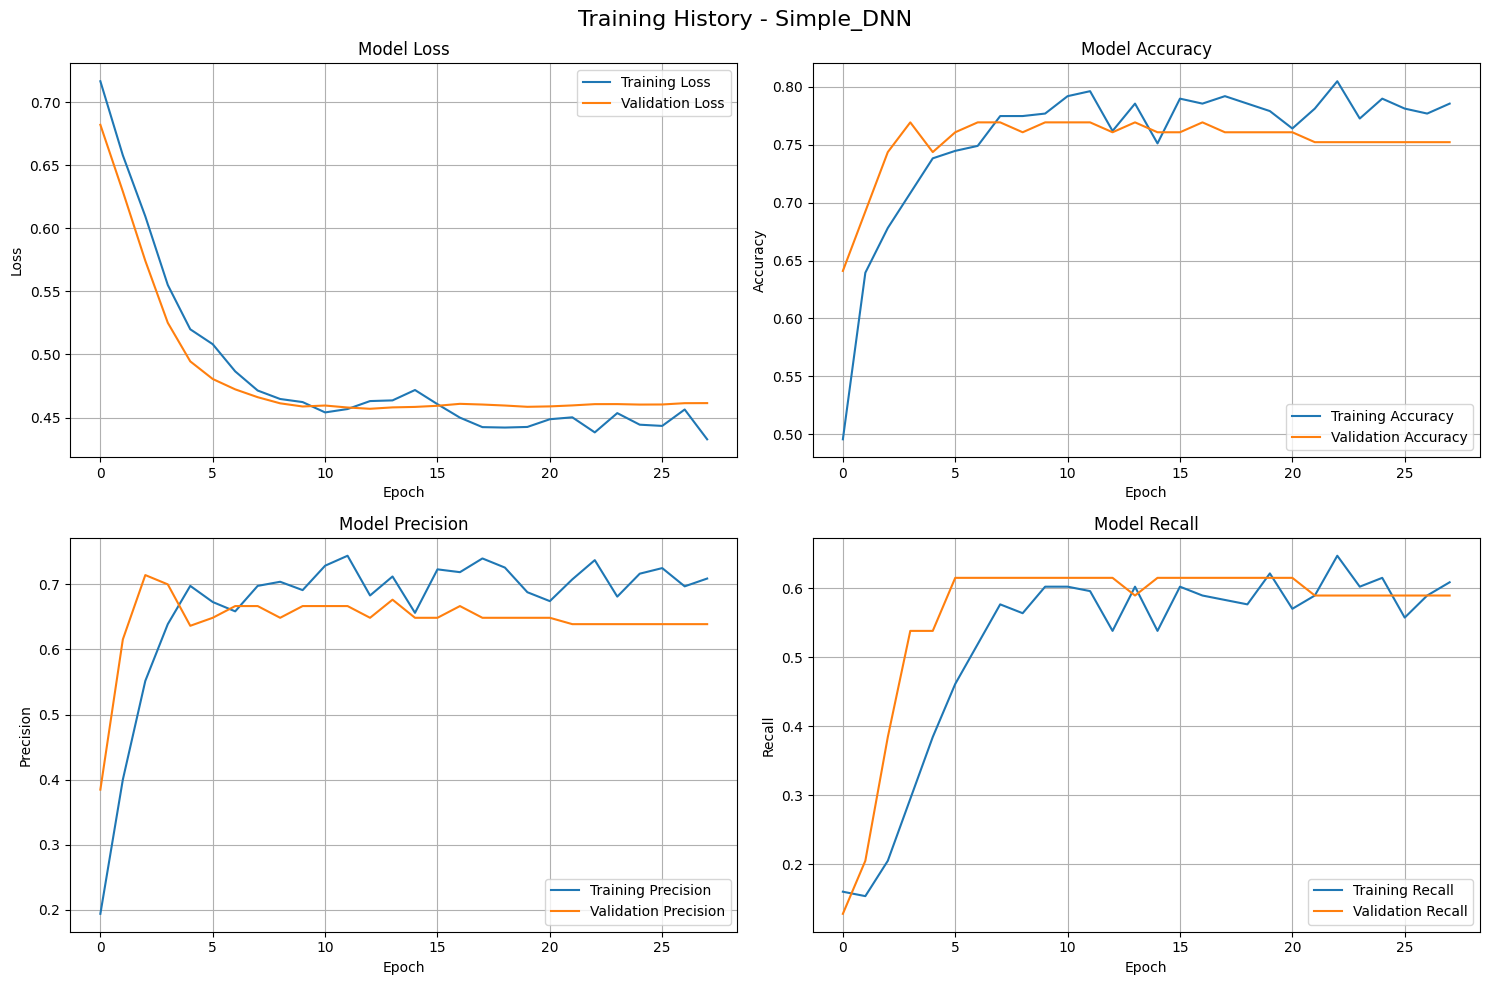

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Evaluation Results for Simple_DNN
Accuracy:  0.8082
Precision: 0.7692
Recall:    0.6122
F1 Score:  0.6818
ROC AUC:   0.8889

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86        97
         1.0       0.77      0.61      0.68        49

    accuracy                           0.81       146
   macro avg       0.80      0.76      0.77       146
weighted avg       0.80      0.81      0.80       146



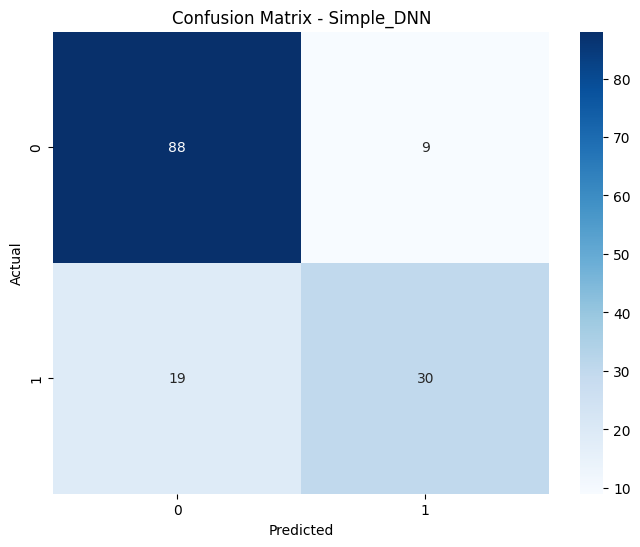

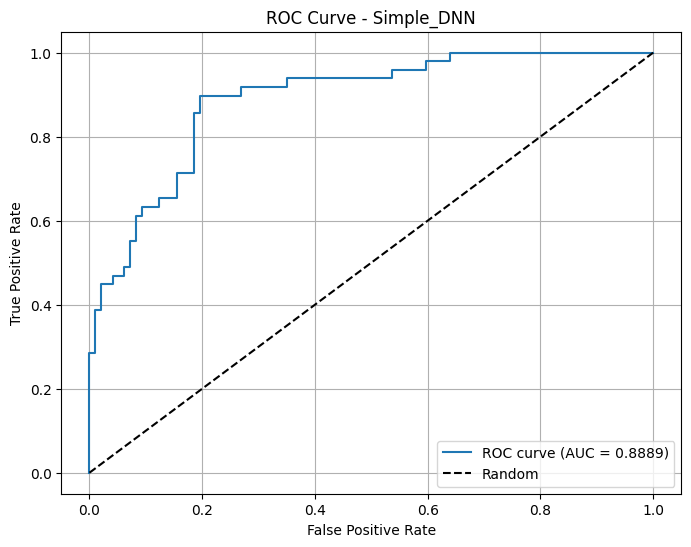


Calculating feature importance for Simple_DNN...


InvalidParameterError: The 'estimator' parameter of permutation_importance must be an object implementing 'fit'. Got <function DiabetesTensorFlowClassifier.get_feature_importance.<locals>.keras_predict at 0x7b25269585e0> instead.

In [ ]:
if __name__ == "__main__":
    # Diasumsikan df_scaled sudah ada dari preprocessing sebelumnya
    # df_scaled = your_preprocessed_dataframe

    # Jalankan klasifikasi
    classifier, results = run_tensorflow_diabetes_classification(df_scaled)

    print("TensorFlow Diabetes Classification Pipeline Ready!")
    print("\nTo use this pipeline:")
    print("1. Load your preprocessed diabetes dataset")
    print("2. Call: classifier, results = run_tensorflow_diabetes_classification(your_dataframe)")
    print("3. The pipeline will train 4 different neural network architectures")
    print("4. Compare results and select the best model")

In [ ]:
'''# Memisahkan fitur dan target
X_final = df_scaled.drop('Outcome', axis=1)
y_final = df_scaled['Outcome']

# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42, stratify=y_final)'''